## PACKAGE

In [8]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from mealpy import FloatVar,GA

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt


## INPUT DATA

In [9]:
#Input Data
df = pd.read_excel(r"C:\Users\User\Downloads\Bismillah Skripsi23 xY.xlsx").set_index('Date')
df.head

<bound method NDFrame.head of                y   x1       x2       x3       x4      x5      x6    x7    x8  \
Date                                                                           
2001-01-01  7.17  879  2096948  5609446  2676998   39547  373077  7.48  9.47   
2001-02-01  5.61  898  1910051  5240820  2309464   26882  328289  5.80  6.45   
2001-03-01  5.23  913  2116381  5041971  2246633   23921  358103  4.93  5.42   
2001-04-01  5.19  957  2028145  5252851  1807170   22637  318573  5.65  5.35   
2001-05-01  4.69  997  2070749  5749464  1522382   28981  321878  5.50  4.95   
...          ...  ...      ...      ...      ...     ...     ...   ...   ...   
2023-08-01  2.58  159  3849638  7631692  2673229  634499  246435  4.70  2.52   
2023-09-01  2.64  161  3761177  7952495  2373200  625625  230008  4.72  2.28   
2023-10-01  2.98  170  3908666  8272556  2438012  621805  230969  5.18  2.36   
2023-11-01  2.89  161  3840525  8206286  2823031  654710  251536  5.49  3.02   
2023-12-01

## FEATURE SELECTION USING RANDOM FOREST

In [21]:
#Define X dan y
X = df.drop(columns=['y'])
y = df['y']
#Check shape
print(X.shape)
print(y.shape)

(276, 14)
(276,)


TUNING PARAMETER MTRY AND NTRY RANDOM FOREST REGRESSOR MODEL

In [12]:
#Random Forest Regressor Model Initialization
model = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=123)
# Define the parameter grid
param_grid = {
    'n_estimators': list(range(100, 1100, 100)),  # List of n_estimators from 100 to 1000
    'max_features': [2, 4, 7, 14]  # List of max_features to try
}

In [13]:
# Buat list untuk menyimpan hasil
results = []

# Loop melalui setiap kombinasi parameter
for n_estimators in param_grid['n_estimators']:
    for max_features in param_grid['max_features']:
        # Set parameter model
        model.set_params(n_estimators=n_estimators, max_features=max_features)
        
        # Latih model
        model.fit(X, y)
        
        # Hitung OOB MSE
        oob_mse = mean_squared_error(y, model.oob_prediction_)
        
        # Simpan hasilnya
        results.append({
            'n_estimators': n_estimators,
            'max_features': max_features,
            'OOB_MSE': oob_mse
        })

# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Temukan kombinasi dengan OOB MSE terkecil
best_index = results_df['OOB_MSE'].idxmin()
best_params = results_df.loc[best_index, ['n_estimators', 'max_features']]
best_oob_mse = results_df.loc[best_index, 'OOB_MSE']

# Tampilkan semua hasil
print(results_df)

# Tampilkan parameter optimal dan OOB MSE terbaik
print(f"Optimal max_features (mtry): {best_params['max_features']}")
print(f"Optimal n_estimators (ntree): {best_params['n_estimators']}")
print(f"Best OOB MSE: {best_oob_mse}")

    n_estimators  max_features   OOB_MSE
0            100             2  0.329178
1            100             4  0.266113
2            100             7  0.286803
3            100            14  0.368480
4            200             2  0.330257
5            200             4  0.262834
6            200             7  0.270710
7            200            14  0.359339
8            300             2  0.332255
9            300             4  0.268968
10           300             7  0.280920
11           300            14  0.359848
12           400             2  0.327806
13           400             4  0.258851
14           400             7  0.277086
15           400            14  0.358643
16           500             2  0.324498
17           500             4  0.252831
18           500             7  0.275143
19           500            14  0.361066
20           600             2  0.322732
21           600             4  0.252754
22           600             7  0.274830
23           600

In [14]:
# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)

# Fit the model
grid_search.fit(X, y)

# Extract all results
results = pd.DataFrame(grid_search.cv_results_)

# Extract OOB scores for all combinations
oob_scores = []
for params in results['params']:
    model.set_params(**params)
    model.fit(X, y)
    oob_score = mean_squared_error(y, model.oob_prediction_)
    oob_scores.append(oob_score)

results['OOB_MSE'] = oob_scores


In [15]:
# Find the combination with the smallest OOB MSE
best_index = results['OOB_MSE'].idxmin()
best_params = results.loc[best_index, 'params']
best_oob_mse = results.loc[best_index, 'OOB_MSE']

# Display all results
results_to_display = results[['params', 'OOB_MSE']]
print(results_to_display)

# Results
print(f"Optimal max_features (mtry): {best_params['max_features']}")
print(f"Optimal n_estimators (ntree): {best_params['n_estimators']}")
print(f"Best OOB MSE: {best_oob_mse}")

                                        params   OOB_MSE
0     {'max_features': 2, 'n_estimators': 100}  0.329178
1     {'max_features': 2, 'n_estimators': 200}  0.330257
2     {'max_features': 2, 'n_estimators': 300}  0.332255
3     {'max_features': 2, 'n_estimators': 400}  0.327806
4     {'max_features': 2, 'n_estimators': 500}  0.324498
5     {'max_features': 2, 'n_estimators': 600}  0.322732
6     {'max_features': 2, 'n_estimators': 700}  0.318869
7     {'max_features': 2, 'n_estimators': 800}  0.316719
8     {'max_features': 2, 'n_estimators': 900}  0.317046
9    {'max_features': 2, 'n_estimators': 1000}  0.317473
10    {'max_features': 4, 'n_estimators': 100}  0.266113
11    {'max_features': 4, 'n_estimators': 200}  0.262834
12    {'max_features': 4, 'n_estimators': 300}  0.268968
13    {'max_features': 4, 'n_estimators': 400}  0.258851
14    {'max_features': 4, 'n_estimators': 500}  0.252831
15    {'max_features': 4, 'n_estimators': 600}  0.252754
16    {'max_features': 4, 'n_es

TRAIN RANDOM FOREST REGRESSOR MODEL 

In [22]:
# Train a RandomForestRegressor with best prameter : mtry 4, ntree 900
model = RandomForestRegressor(n_estimators=900, max_features=4, bootstrap=True, oob_score=True, random_state=123) 
model.fit(X,y)
# Calculate the OOB predictions
oob_predictions = model.oob_prediction_

# Calculate the MSE for OOB predictions
mse_oob = mean_squared_error(y, oob_predictions)
r2 =r2_score(y, oob_predictions)
mape_oob = mean_absolute_percentage_error(y, oob_predictions) *100
print(f'Mean Squared Error (MSE) for OOB predictions: {mse_oob:.4f}')
print(f'R-squared : {r2}')
print (f'MAPE : {mape_oob}')

Mean Squared Error (MSE) for OOB predictions: 0.2518
R-squared : 0.9427831233353876
MAPE : 7.682922130097092


In [23]:
#Create an OOB matrix
n_samples =X.shape[0]
oob_data = np.zeros((n_samples, model.n_estimators))

# Utility function to get unsampled indices
def _generate_unsampled_indices(random_state, n_samples, n_estimators):
    rng = check_random_state(random_state)
    sample_indices = rng.randint(0, n_samples, (n_estimators, n_samples))
    unsampled_indices = [np.setdiff1d(np.arange(n_samples), sample_indices[i]) for i in range(n_estimators)]
    return unsampled_indices

unsampled_indices = _generate_unsampled_indices(model.random_state, n_samples, model.n_estimators)
for i in range(model.n_estimators):
    oob_data[unsampled_indices[i], i] = 1

print("OOB Data Matrix:")
print(oob_data)

# Create a list of DataFrames for OOB samples per tree
oob_data_list = []
for i in range(model.n_estimators):
    oob_indices = unsampled_indices[i]
    oob_data_list.append(df.iloc[oob_indices])

# Assign OOB data per tree to variables qw_1, qw_2, ..., qw_900
for i, df_oob in enumerate(oob_data_list):
    globals()[f'qw_{i+1}'] = df_oob

# For demonstration, print the first few OOB samples for the first tree
print("\nFirst few OOB samples for the first tree:")
print(qw_1.head())

OOB Data Matrix:
[[1. 0. 0. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 1.]]

First few OOB samples for the first tree:
               y    x1       x2       x3       x4     x5      x6    x7    x8  \
Date                                                                           
2001-01-01  7.17   879  2096948  5609446  2676998  39547  373077  7.48  9.47   
2001-06-01  3.72  1050  1993266  6192512  1444378  24554  317414  4.64  3.94   
2001-10-01  2.46   913  2097034  7453778  1649073  32452  326114  2.74  2.14   
2001-12-01  2.30   754  2074278  7204251  2120198  41564  309673  2.76  2.68   
2002-02-01  2.32   679  1858737  6193791  2242427  38383  305917  2.42  2.32   

               x9    x10   x11      x12      x13    x14  
Date                                                     
2001-01-01  0.728  26.97  6.75  303.197  305.297  31.35  
2001-06-01  0.777  27.58  7.58  298.272  294.920 

In [24]:
# Create vectors yact for the actual y values from the OOB data per tree
yact = []
for i in range(model.n_estimators):
    df_oob = globals()[f'qw_{i+1}']
    yact.append(df_oob['y'])

# Create vectors ypred for the predicted y values from the OOB data per tree
ypred = []
for i in range(model.n_estimators):
    df_oob = globals()[f'qw_{i+1}']
    ypred.append(model.estimators_[i].predict(df_oob.drop(columns=['y'])))

# For demonstration, print the actual and predicted y values for the first tree
print("\nActual y values for the first tree:")
print(yact[0])

print("\nPredicted y values for the first tree:")
print(ypred[0])

c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi


Actual y values for the first tree:
Date
2001-01-01    7.17
2001-06-01    3.72
2001-10-01    2.46
2001-12-01    2.30
2002-02-01    2.32
              ... 
2023-04-01    2.46
2023-09-01    2.64
2023-10-01    2.98
2023-11-01    2.89
2023-12-01    2.74
Name: y, Length: 107, dtype: float64

Predicted y values for the first tree:
[ 5.39  3.72  2.46  2.3   2.3   3.5   3.11  4.04  5.43  5.39  5.03  3.72
  4.63  4.47  5.71  6.33  6.27  6.33  6.15  6.15  7.1   9.53 13.05  6.17
  6.74  7.11  7.11  6.74  6.22  7.1   8.69  8.26  6.74  5.82  3.8   3.38
  3.78  5.83  4.63  4.71  4.09  4.54  3.17  2.67  2.17  2.95  3.54  3.33
  4.17  4.04  3.62  3.43  4.24  4.71  4.58  4.66  4.05  3.92  4.12  2.83
  2.3   2.85  2.84  2.34  2.09  2.3   1.99  1.73  1.92  2.59  2.99  2.88
  3.3   3.15  2.82  2.99  2.88  3.01  3.01  3.87  2.4   2.83  2.96  3.
  3.01  2.4   2.65  2.02  3.1   1.74  1.74  1.92  2.39  2.62  4.04  4.61
  4.68  5.4   5.4   2.61  2.89  2.61  2.46  2.64  2.18  2.89  2.61]


c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi

In [25]:
# Calculate initial MSE for each tree
mseawal_pohon = []
for i in range(model.n_estimators):
    mse = mean_squared_error(yact[i], ypred[i])
    mseawal_pohon.append(mse)

print("\nInitial MSE for each tree:")
print(mseawal_pohon)

# Predictor variables list
predictor_variables = ["x1", "x2", "x3", "x4", "x5", "x6",
                       "x7", "x8", "x9", "x10", "x11", "x12", "x13",
                       "x14"]  # Replace with actual predictor variables
num_predictors = len(predictor_variables)

# Create copies of OOB data with permuted variables for each tree
for i in range(model.n_estimators):
    for j in range(num_predictors):
        var_name = f'copy_data_tree_{i+1}_variable_{j+1}'
        globals()[var_name] = globals()[f'qw_{i+1}'].copy()

# Permute the predictor variables in the OOB data for each tree
for i in range(model.n_estimators):
    for j in range(num_predictors):
        copy_data_var_name = globals()[f'copy_data_tree_{i+1}_variable_{j+1}']
        permuted_var_name = np.random.permutation(copy_data_var_name[predictor_variables[j]])
        copy_data_var_name[predictor_variables[j]] = permuted_var_name
        globals()[f'copy_data_tree_{i+1}_variable_{j+1}'] = copy_data_var_name
        globals()[f'data_permuted_tree_{i+1}_variable_{j+1}'] = copy_data_var_name

# For demonstration, print the first few permuted OOB samples for the first tree and first variable
print("\nFirst few permuted OOB samples for the first tree and first variable:")
print(globals()['data_permuted_tree_1_variable_1'].head())


Initial MSE for each tree:
[np.float64(0.21397757009345797), np.float64(0.40473913043478255), np.float64(0.23763428571428571), np.float64(0.16745283018867924), np.float64(0.24641010101010097), np.float64(0.23810816326530607), np.float64(0.13392547169811322), np.float64(0.2981175925925926), np.float64(0.2633869565217391), np.float64(0.4903082474226804), np.float64(0.15633465346534653), np.float64(0.5496504854368932), np.float64(0.21857499999999996), np.float64(0.1544116504854369), np.float64(0.24268163265306125), np.float64(0.3476083333333333), np.float64(0.2812927835051546), np.float64(0.3515645161290323), np.float64(0.24659223300970876), np.float64(0.24916538461538457), np.float64(0.7210607843137256), np.float64(0.4436824074074074), np.float64(0.3404495145631068), np.float64(0.2570603603603604), np.float64(0.4025811881188118), np.float64(0.15572685185185187), np.float64(0.15071792452830182), np.float64(0.3918217821782178), np.float64(0.13958), np.float64(0.236479), np.float64(0.22789

In [26]:
# Step 10: Extract the actual y values from the permuted OOB data for each tree and variable
y_act_datapermute = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        data_asli_permutasi_var_name = globals()[f'data_permuted_tree_{i+1}_variable_{j+1}']
        y_act_datapermute[(i+1, j+1)] = data_asli_permutasi_var_name['y']

# Step 11: Predict y values using the permuted OOB data for each tree and variable
y_pred_datapermute = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        data_asli_permutasi_var_name = globals()[f'data_permuted_tree_{i+1}_variable_{j+1}']
        X_permuted = data_asli_permutasi_var_name.drop(columns=['y'])
        y_pred_datapermute[(i+1, j+1)] = model.estimators_[i].predict(X_permuted)

# For demonstration, print a few actual and predicted y values from the permuted OOB data for the first tree and first variable
print("\nActual y values from the permuted OOB data for the first tree and first variable:")
print(y_act_datapermute[(1, 1)].head())

print("\nPredicted y values from the permuted OOB data for the first tree and first variable:")
print(y_pred_datapermute[(1, 1)][:5])


c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi


Actual y values from the permuted OOB data for the first tree and first variable:
Date
2001-01-01    7.17
2001-06-01    3.72
2001-10-01    2.46
2001-12-01    2.30
2002-02-01    2.32
Name: y, dtype: float64

Predicted y values from the permuted OOB data for the first tree and first variable:
[5.39 3.72 2.3  2.09 2.09]


c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\User\miniconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi

In [27]:
# Step 12: Calculate MSE for the permuted OOB data for each tree and each variable
mse_datapermute = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        y_act_datapermute_var_name = y_act_datapermute[(i+1, j+1)]
        y_pred_datapermute_var_name = y_pred_datapermute[(i+1, j+1)]
        mse = mean_squared_error(y_act_datapermute_var_name, y_pred_datapermute_var_name)
        mse_datapermute[(i+1, j+1)] = mse

# Step 13: Compute delta MSE for each tree and each variable
deltamse = {}
for i in range(model.n_estimators):
    for j in range(num_predictors):
        mse_datapermute_var_name = mse_datapermute[(i+1, j+1)]
        mseawal_var_name = mseawal_pohon[i]
        deltamse_var_name = mse_datapermute_var_name - mseawal_var_name
        deltamse[(i+1, j+1)] = deltamse_var_name

# Step 14: Calculate PVIM for each variable
vec_variabel = {}
for j in range(num_predictors):
    temp_vec = []
    for i in range(model.n_estimators):
        deltamse_var_name = deltamse[(i+1, j+1)]
        temp_vec.append(deltamse_var_name)
    vec_variabel[j+1] = temp_vec

PVIM = {}
for j in range(num_predictors):
    vec_var_name = vec_variabel[j+1]
    PVIM_var_name = np.mean(vec_var_name) 
    PVIM[j+1] = PVIM_var_name

# For demonstration, print the PVIM values
print("\nPermutation Variable Importance Measure (PVIM) for each variable:")
for j in range(num_predictors):
    print(f"Variable {j+1}: {PVIM[j+1]:.4f}")
    
print(f"\nTotal PVIM for all variables: {sum(PVIM.values()):.4f}")


Permutation Variable Importance Measure (PVIM) for each variable:
Variable 1: 0.8568
Variable 2: 0.2147
Variable 3: 0.0529
Variable 4: 0.0844
Variable 5: 0.2795
Variable 6: 0.1945
Variable 7: 1.7214
Variable 8: 2.2707
Variable 9: 0.2096
Variable 10: 0.1905
Variable 11: 0.1299
Variable 12: 0.3191
Variable 13: 0.3814
Variable 14: 0.0568

Total PVIM for all variables: 6.9622


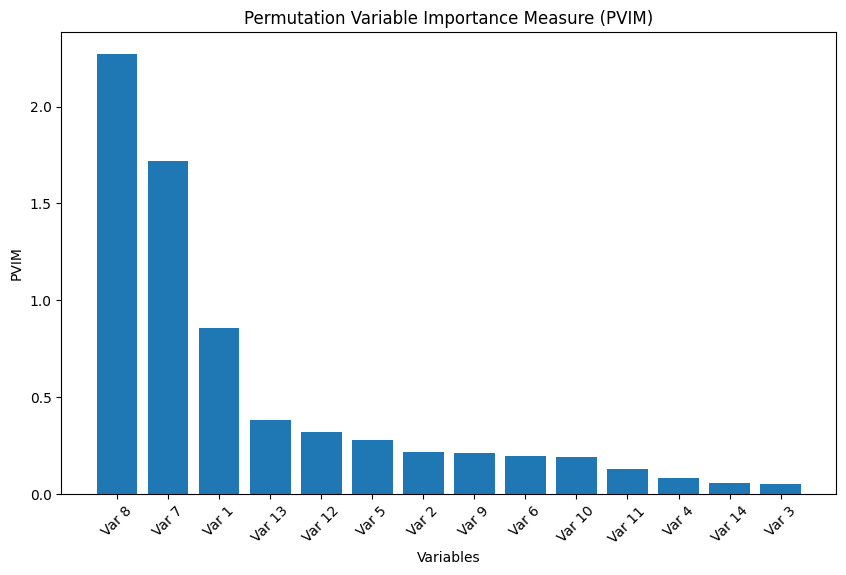

In [28]:
# Konversi PVIM ke array numpy
feature_names = list(PVIM.keys())
importances = np.array(list(PVIM.values()))
# Urutkan nilai PVIM dan nama fitur
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]
# Plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=[f'Var {i}' for i in sorted_feature_names])
plt.xlabel('Variables')
plt.ylabel('PVIM')
plt.title('Permutation Variable Importance Measure (PVIM)')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Mengurutkan PVIM berdasarkan nilai
sorted_pvim = sorted(PVIM.items(), key=lambda item: item[1], reverse=True)

# Mencetak hasil yang sudah diurutkan
print("\nPermutation Variable Importance Measure (PVIM) for each variable:")
total_pvim = sum(PVIM.values())
for var, importance in sorted_pvim:
    print(f"Variable {var}: {importance / total_pvim * 100:.4f}")



Permutation Variable Importance Measure (PVIM) for each variable:
Variable 8: 32.6149
Variable 7: 24.7246
Variable 1: 12.3059
Variable 13: 5.4781
Variable 12: 4.5836
Variable 5: 4.0149
Variable 2: 3.0834
Variable 9: 3.0107
Variable 6: 2.7932
Variable 10: 2.7368
Variable 11: 1.8658
Variable 4: 1.2123
Variable 14: 0.8162
Variable 3: 0.7596


SHOWS THE MSE RESULTS FOR EACH TREE

In [65]:
# Extract MSE values before permutation for each tree
mse_before_permutation = mseawal_pohon

# Extract MSE values after permutation for the each variable 
mse_after_permutation_xi = [mse_datapermute[(i+1, 1)] for i in range(model.n_estimators)] #ganti angka setelah i+1, jika ingin melihat tiap variabelnya

# Create a DataFrame to display the results
mse_comparison_df = pd.DataFrame({
    'Tree': range(1, model.n_estimators + 1),
    'MSE Before Permutation': mse_before_permutation,
    'MSE After Permutation (xi)': mse_after_permutation_xi
})
# Add the MSE Difference column
mse_comparison_df['MSE Difference'] = mse_comparison_df['MSE After Permutation (xi)'] - mse_comparison_df['MSE Before Permutation']

# Display the DataFrame
pd.set_option('display.max_rows', None)
mse_comparison_df # Display the first 10 rows for a preview


,Tree,MSE Before Permutation,MSE After Permutation (xi),MSE Difference
0,1,0.213978,2.776334,2.562356
1,2,0.404739,1.695035,1.290296
2,3,0.237634,1.465220,1.227586
3,4,0.167453,0.370283,0.202830
4,5,0.246410,0.824226,0.577816
5,6,0.238108,1.146693,0.908585
6,7,0.133925,0.278933,0.145008
7,8,0.298118,0.396376,0.098258
8,9,0.263387,1.021212,0.757825
9,10,0.490308,0.777874,0.287566


## SUPPORT VECTOR REGRESSION

In [31]:
#Use the data feature selected
df_fs = df.drop(['x2', 'x3', 'x4', 'x6', 'x9','x10', 'x11','x14'],axis=1)
df_fs.head()

,y,x1,x5,x7,x8,x12,x13
Date,,,,,,,
2001-01-01,7.17,879,39547,7.48,9.47,303.197,305.297
2001-02-01,5.61,898,26882,5.80,6.45,272.585,272.999
2001-03-01,5.23,913,23921,4.93,5.42,301.844,302.202
2001-04-01,5.19,957,22637,5.65,5.35,288.028,287.200
2001-05-01,4.69,997,28981,5.50,4.95,290.338,289.692


## Preprocessing

MinMax scaling untuk data asli dan feature-selected
Split train test, no shuffle, 85:15

In [32]:
# Scaling data asli
scaler = MinMaxScaler().set_output(transform = 'pandas')
df_scaled = scaler.fit_transform(df.drop('y', axis = 1))
df_scaled['y'] = df['y']

# Scaling data feature selected
scaler_fs = MinMaxScaler().set_output(transform = 'pandas')
df_fs_scaled = scaler_fs.fit_transform(df_fs.drop('y', axis = 1))
df_fs_scaled['y'] = df_fs['y']

In [33]:
# Split data asli
X = df_scaled.drop('y', axis = 1)
y = df_scaled['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle = False)

# Split data feature selected
X_fs = df_fs_scaled.drop('y', axis = 1)
y_fs = df_fs_scaled['y']
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size = 0.15, shuffle = False)

## Fungsi utk hitung metrics R2, RMSE, MAE

Intinya ini fungsi otomatis ngitung R2, RMSE, dan MAE buat data train dan data test

In [35]:
def compute_metrics(model, X_train, X_test, y_train, y_test):
    X_train_predict = model.predict(X_train)
    r2_train = r2_score(y_train, X_train_predict)
    rmse_train = np.sqrt(mean_squared_error(y_train, X_train_predict))
    mae_train = mean_absolute_error(y_train, X_train_predict)
    mape_train = mean_absolute_percentage_error(y_train, X_train_predict)*100

    X_test_predict = model.predict(X_test)
    r2_test = r2_score(y_test, X_test_predict)
    rmse_test = np.sqrt(mean_squared_error(y_test, X_test_predict))
    mae_test = mean_absolute_error(y_test, X_test_predict)
    mape_test = mean_absolute_percentage_error(y_test, X_test_predict)*100

    return(pd.DataFrame({'R2' : [r2_train, r2_test],
                        'RMSE' : [rmse_train, rmse_test],
                        'MAE' : [mae_train, mae_test],
                        'MAPE' : [mape_train, mape_test]},
                index = ['Train', 'Test']))

TRAIN SVR MODELS DEFAULT

In [36]:
#Train use Data Asli
svr_asli = SVR(kernel='rbf')
svr_asli.fit(X_train, y_train)

# Hitung metrics train dan test
compute_metrics(svr_asli, X_train, X_test, y_train, y_test)

,R2,RMSE,MAE,MAPE
Train,0.927281,0.582078,0.286576,6.101700
Test,0.581267,1.040294,0.764579,20.599241


In [37]:
#Train use Data Feature Selected
svr_fs = SVR(kernel='rbf')
svr_fs.fit(X_fs_train, y_fs_train)

# Hitung metrics train dan test
compute_metrics(svr_fs, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

,R2,RMSE,MAE,MAPE
Train,0.947726,0.493512,0.292514,6.896664
Test,0.623436,0.986522,0.668050,15.752621


## HYBRID RF-SVR-GA MODELS

In [38]:
best_svr_fs_ga = None
best_svr_fs_ga_metric = 999

def svr_fs_fitness(parameter):
    global X_fs_train, X_fs_test, y_fs_train, y_fs_test, best_svr_fs_ga, best_svr_fs_ga_metric

    C = parameter[0]
    epsilon = parameter[1]
    gamma = parameter[2]

    svr = SVR(C = C, epsilon=epsilon, gamma = gamma, kernel='rbf', tol = 1e-5)
    svr.fit(X_fs_train, y_fs_train)

    result = compute_metrics(svr, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

    # Minimumkan MAPE pada data test
    fitness = result.loc['Test', 'MAPE']

    # Simpan model terbaika
    if best_svr_fs_ga_metric > fitness:
        best_svr_fs_ga = svr
        best_svr_fs_ga_metric = fitness

    return fitness


svr_fs_hyperparameter = {
    'obj_func' : svr_fs_fitness,
    'bounds' : FloatVar(lb = [1, 0, 0], ub = [10, 5, 1]),
    'minmax' : 'max'
}

optimizer_fs = GA.BaseGA(epoch = 150, pop_size = 100, random_state = 123, pm=0.1, pc=0.8)
optimizer_fs.solve(svr_fs_hyperparameter)

# Tampilkan metrics train dan test dari model terbaik
print(compute_metrics(best_svr_fs_ga, X_fs_train, X_fs_test, y_fs_train, y_fs_test))
# show the best hyperparametes
print(best_svr_fs_ga)

2024/07/17 06:36:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


2024/07/17 06:36:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 108.43983313192147, Global best: 108.43983313192147, Runtime: 1.16843 seconds
2024/07/17 06:36:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 108.43983313192147, Global best: 108.43983313192147, Runtime: 1.06162 seconds
2024/07/17 06:36:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 108.45911841114884, Global best: 108.45911841114884, Runtime: 1.07155 seconds
2024/07/17 06:36:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 108.45911841114884, Global best: 108.45911841114884, Runtime: 1.10015 seconds
2024/07/17 06:36:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 108.45911841114884, Global best: 108.45911841114884, Runtime: 1.22476 seconds
2024/07/17 06:36:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

             R2      RMSE       MAE       MAPE
Train  0.944543  0.508315  0.331962   7.809573
Test   0.837906  0.647248  0.430779  10.613899
SVR(C=np.float64(5.678214793456479), epsilon=np.float64(0.25461858734068366),
    gamma=np.float64(0.2272987127182754), tol=1e-05)


## SHOW Y PREDICTIONS

In [91]:

# Creating DataFrame with original index
y_fsga_train_predict = svr_fs_ga.predict(X_fs_train)
df_y_fsga_train_predict = pd.DataFrame(y_fsga_train_predict, columns=['Predicted'], index=y_fs_train.index)
df_y_fsga_train_predict

# Mengubah pengaturan tampilan untuk menampilkan semua baris
pd.set_option('display.max_rows', None)

# Menampilkan semua baris dari DataFrame
print(df_y_fsga_train_predict)

            Predicted
Date                 
2001-01-01   7.953656
2001-02-01   5.996919
2001-03-01   5.081972
2001-04-01   5.558239
2001-05-01   5.330524
2001-06-01   4.460571
2001-07-01   3.557487
2001-08-01   3.447337
2001-09-01   2.874548
2001-10-01   2.675439
2001-11-01   3.161112
2001-12-01   2.778303
2002-01-01   2.874855
2002-02-01   2.510711
2002-03-01   2.745955
2002-04-01   3.374202
2002-05-01   3.245026
2002-06-01   3.155294
2002-07-01   3.107927
2002-08-01   2.899279
2002-09-01   3.239173
2002-10-01   3.577199
2002-11-01   4.014385
2002-12-01   4.114017
2003-01-01   5.164504
2003-02-01   5.981938
2003-03-01   7.844361
2003-04-01   4.991131
2003-05-01   5.197314
2003-06-01   5.661252
2003-07-01   5.121739
2003-08-01   4.686965
2003-09-01   4.787642
2003-10-01   4.494127
2003-11-01   4.512040
2003-12-01   5.080830
2004-01-01   5.859920
2004-02-01   5.578142
2004-03-01   5.099367
2004-04-01   5.353808
2004-05-01   5.853492
2004-06-01   6.227192
2004-07-01   5.869583
2004-08-01

In [89]:
# Creating DataFrame with original index
y_fsga_test_predict = svr_fs_ga.predict(X_fs_test)
df_y_fsga_test_predict = pd.DataFrame(y_fsga_test_predict, columns=['Predicted'], index=y_fs_test.index)
df_y_fsga_test_predict 

,Predicted
Date,
2020-07-01,2.165308
2020-08-01,2.212940
2020-09-01,2.350785
2020-10-01,2.289753
2020-11-01,2.669547
2020-12-01,2.798123
2021-01-01,2.585440
2021-02-01,7.459419
2021-03-01,2.647595


## HASIL PREDIKSI 3 BULAN KEDEPAN

In [88]:
# Menghitung metrics data asli
metrics_asli = compute_metrics(svr_asli, X_train, X_test, y_train, y_test)

# Hitung metrics train dan test untuk data feature selected
metrics_fs = compute_metrics(svr_fs, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

#model hybrid
# Melatih model feature selected
svr_fs_ga = SVR(C=best_svr_fs_ga.C, epsilon=best_svr_fs_ga.epsilon, gamma=best_svr_fs_ga.gamma, tol=1e-05, kernel='rbf')
svr_fs_ga.fit(X_fs_train, y_fs_train)


# Data baru untuk 3 bulan
data_baru_3_bulan = pd.DataFrame({
    'x1' :[119 , 120, 115],
    'x5':[673868 ,643565 ,667952],
    'x7': [5.4, 4.62, 3.79],
    'x8': [4.59, 2.44, 1.63],
    'x12': [683.075, 698.671, 769.474],
    'x13': [661.948, 681.627, 749.438],
}, index=pd.date_range(start='2024-01-01', periods=3, freq='M'))

# Pastikan kolom data baru sesuai dengan data feature selected
missing_cols = set(X_fs.columns) - set(data_baru_3_bulan.columns)
extra_cols = set(data_baru_3_bulan.columns) - set(X_fs.columns)

# Tambahkan kolom yang hilang dengan nilai 0
for col in missing_cols:
    data_baru_3_bulan[col] = 0

# Hapus kolom ekstra
data_baru_3_bulan = data_baru_3_bulan[X_fs.columns]

# Lakukan scaling pada data baru
data_baru_3_bulan_scaled = scaler_fs.transform(data_baru_3_bulan)

# Melakukan prediksi
prediksi_3_bulan = svr_fs_ga.predict(data_baru_3_bulan_scaled)

# Menggabungkan hasil prediksi dengan index (tanggal)
hasil_prediksi = pd.DataFrame(prediksi_3_bulan, index=data_baru_3_bulan.index, columns=['Prediksi_y'])

print("Metrics untuk model asli:")
print(metrics_asli)

print("\nMetrics untuk model dengan fitur yang dipilih:")
print(metrics_fs)

print("\nHasil prediksi untuk 3 bulan ke depan:")
print(hasil_prediksi)

Metrics untuk model asli:
             R2      RMSE       MAE       MAPE
Train  0.927281  0.582078  0.286576   6.101700
Test   0.581267  1.040294  0.764579  20.599241

Metrics untuk model dengan fitur yang dipilih:
             R2      RMSE       MAE       MAPE
Train  0.947726  0.493512  0.292514   6.896664
Test   0.623436  0.986522  0.668050  15.752621

Hasil prediksi untuk 3 bulan ke depan:
            Prediksi_y
2024-01-31    3.023073
2024-02-29    2.516640
2024-03-31    2.298727


C:\Users\User\AppData\Local\Temp\ipykernel_19704\2347577990.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range(start='2024-01-01', periods=3, freq='M'))


## TAMBAHAN JIKA INGIN MELIHAT HASIL PREDIKSI 3 BULAN KEDEPAN SVR, RF-SVR, RF-SVR-GA

In [ ]:
# Menghitung metrics using data asli
metrics_asli = compute_metrics(svr_asli, X_train, X_test, y_train, y_test)

# Hitung metrics train dan test untuk data feature selected
metrics_fs = compute_metrics(svr_fs, X_fs_train, X_fs_test, y_fs_train, y_fs_test)

# Data baru untuk 3 bulan
data_baru_3_bulan = pd.DataFrame({
    'x1' :[119 , 120, 115],
    'x2' :[3871729, 3717663, 3875008],
    'x3' :[7079735, 6818144, 6767794],
    'x4' :[3696738, 2969222, 2791422],
    'x5':[673868 ,643565 ,667952],
    'x6' :[323451, 258880, 241256],
    'x7': [5.4, 4.62, 3.79],
    'x8': [4.59, 2.44, 1.63],
    'x9' : [2.535, 2.589, 2.604],
    'x10' :[73.73, 75.55, 78.67],
    'x11' : [12.73, 12.8, 12.73],
    'x12': [683.075, 698.671, 769.474],
    'x13': [661.948, 681.627, 749.438],
    'x14' : [31.93, 40.87, 45.01],
}, index=pd.date_range(start='2024-01-01', periods=3, freq='M'))

# Pastikan kolom data baru sesuai dengan data feature selected
missing_cols = set(X_fs.columns) - set(data_baru_3_bulan.columns)
extra_cols = set(data_baru_3_bulan.columns) - set(X_fs.columns)

# Tambahkan kolom yang hilang dengan nilai 0
for col in missing_cols:
    data_baru_3_bulan[col] = 0

# Hapus kolom ekstra
data_baru_3_bulan_svr = data_baru_3_bulan[X.columns]
data_baru_3_bulan_rfsvr = data_baru_3_bulan[X_fs.columns]
data_baru_3_bulan_rfsvrga = data_baru_3_bulan[X_fs.columns]

# Lakukan scaling pada data baru
data_baru_3_bulan_svr_scaled = scaler.transform(data_baru_3_bulan_svr)
data_baru_3_bulan_rfsvr_scaled = scaler_fs.transform(data_baru_3_bulan_rfsvr)
data_baru_3_bulan_rfsvrga_scaled = scaler_fs.transform(data_baru_3_bulan_rfsvrga)

# Melakukan prediksi
prediksi_3_bulan_svr = svr_asli.predict(data_baru_3_bulan_svr_scaled)
prediksi_3_bulan_rfsvr = svr_fs.predict(data_baru_3_bulan_rfsvr_scaled)
prediksi_3_bulan_rfsvrga = svr_fs_ga.predict(data_baru_3_bulan_rfsvrga_scaled)

# Menggabungkan hasil prediksi dengan index (tanggal)
hasil_prediksi_svr = pd.DataFrame(prediksi_3_bulan_svr, index=data_baru_3_bulan_svr.index, columns=['Prediksi_y_svr'])
hasil_prediksi_rfsvr = pd.DataFrame(prediksi_3_bulan_rfsvr, index=data_baru_3_bulan_rfsvr.index, columns=['Prediksi_y_rfsvr'])
hasil_prediksi_rfsvrga = pd.DataFrame(prediksi_3_bulan_rfsvrga, index=data_baru_3_bulan_rfsvrga.index, columns=['Prediksi_y_rfsvrga'])


print("Metrics untuk model asli:")
print(metrics_asli)

print("\nMetrics untuk model dengan fitur yang dipilih:")
print(metrics_fs)

print("\nHasil prediksi untuk 3 bulan ke depan model hybrid:")
print(hasil_prediksi_rfsvrga)

print("\nHasil prediksi untuk 3 bulan ke depan model svr:")
print(hasil_prediksi_rfsvr)

print("\nHasil prediksi untuk 3 bulan ke depan model rf-svr:")
print(hasil_prediksi_svr)